Öğrenci Adı:	 ABDUL RAHMAN

Öğrenci Soyadı:	KHANOUM

Öğrenci No:	2212721317

GitHub Projesi:	https://github.com/Abood88088/YoloV8_Nesne_Tespiti-

📌 YOLOv8 Tabanlı Elma ve Adaptör Nesne Tespiti

Bu çalışmada, günlük hayatta sıkça kullanılan elma (apple) ve telefon adaptörü (adapter) nesnelerinin otomatik olarak tespit edilmesini amaçlayan bir YOLOv8 tabanlı nesne tespit modeli geliştirilmiştir. Proje kapsamında kullanılan tüm görseller tarafımdan farklı ortam ve açılarda çekilmiş gerçek fotoğraflardan oluşmaktadır.

Oluşturulan veri seti, YOLO formatına uygun şekilde etiketlenmiş ve eğitim (train) ile doğrulama (validation) olmak üzere iki alt kümeye ayrılmıştır. Model eğitimi sırasında 640×640 çözünürlükte giriş görüntüleri kullanılmış, eğitim süreci 60 epoch boyunca yürütülmüştür.

Eğitim tamamlandıktan sonra elde edilen best.pt ağırlık dosyası kullanılarak modelin farklı sahnelerdeki performansı test edilmiştir. Test sonuçları, elma ve adaptör nesnelerinin farklı zeminler, arka planlar ve ışık koşulları altında başarılı şekilde algılanabildiğini göstermektedir.

Ayrıca eğitilen model, Python ve PyQt5 kütüphaneleri kullanılarak geliştirilen bir masaüstü grafik arayüzüne entegre edilmiştir. Bu arayüz sayesinde kullanıcılar tek bir görsel seçerek nesne tespit işlemini kolayca gerçekleştirebilmektedir.

Bu proje kapsamında gerçekleştirilen başlıca çalışmalar aşağıda özetlenmiştir:

• Gerçek görüntülerden oluşan veri seti hazırlanması

• YOLO formatında etiketleme işlemleri

• Veri setinin train / validation olarak bölünmesi

• YOLOv8 mimarisi ile özel model eğitimi

• Eğitilen modelin test edilmesi ve sonuçların görselleştirilmesi

• Python + PyQt5 kullanılarak masaüstü GUI geliştirilmesi

Bu çalışma, YOLOv8 mimarisinin sınırlı sayıda sınıfa sahip özel veri setleri üzerinde etkili sonuçlar üretebildiğini ortaya koymaktadır.


1. Dataset ZIP dosyasını açma

In [ ]:
!unzip -q dataset.zip -d /content


2. Klasör yapısını kontrol etme

In [ ]:
!ls /content
!ls /content/dataset


dataset  dataset.zip  sample_data
images	labels


3. Görsel ve etiket dosyalarını yeniden adlandırma

In [ ]:
from pathlib import Path

BASE = Path("/content/dataset")
classes = ["apple", "adapter"]
img_exts = [".jpg", ".jpeg", ".png"]

for cls in classes:
    img_dir = BASE / "images" / cls
    lbl_dir = BASE / "labels" / cls

    for img in img_dir.iterdir():
        if img.suffix.lower() not in img_exts:
            continue

        new_img = img_dir / f"{cls}_{img.name}"
        old_lbl = lbl_dir / f"{img.stem}.txt"
        new_lbl = lbl_dir / f"{cls}_{img.stem}.txt"

        if not new_img.exists():
            img.rename(new_img)

        if old_lbl.exists() and not new_lbl.exists():
            old_lbl.rename(new_lbl)

print("Renaming done")


✅ Renaming done


4. Yeniden adlandırılan dosyaları kontrol etme

In [ ]:
!ls /content/dataset/images/apple | head
!ls /content/dataset/labels/apple | head


apple_img100.jpg
apple_img10.jpg
apple_img11.jpg
apple_img12.jpg
apple_img13.jpg
apple_img14.jpg
apple_img15.jpg
apple_img16.jpg
apple_img17.jpg
apple_img18.jpg
apple_img100.txt
apple_img10.txt
apple_img11.txt
apple_img12.txt
apple_img13.txt
apple_img14.txt
apple_img15.txt
apple_img16.txt
apple_img17.txt
apple_img18.txt


5. Train / Validation bölme işlemi

In [ ]:
import random, shutil
from pathlib import Path

random.seed(42)

BASE = Path("/content/dataset")
IMG_SRC = BASE / "images"
LBL_SRC = BASE / "labels"

splits = {"train": 0.8, "val": 0.2}
img_exts = [".jpg", ".jpeg", ".png"]

for split in splits:
    (IMG_SRC / split).mkdir(exist_ok=True)
    (LBL_SRC / split).mkdir(exist_ok=True)

samples = []

for cls in ["apple", "adapter"]:
    for img in (IMG_SRC / cls).iterdir():
        if img.suffix.lower() in img_exts:
            samples.append((cls, img.name))

random.shuffle(samples)

n = len(samples)
n_train = int(n * splits["train"])

train_set = samples[:n_train]
val_set = samples[n_train:]

def move_pair(cls, img_name, split):
    shutil.copy2(IMG_SRC/cls/img_name, IMG_SRC/split/img_name)
    shutil.copy2(LBL_SRC/cls/(Path(img_name).stem + ".txt"),
                 LBL_SRC/split/(Path(img_name).stem + ".txt"))

for cls, img in train_set:
    move_pair(cls, img, "train")

for cls, img in val_set:
    move_pair(cls, img, "val")

print("Split done")
print("Train:", len(train_set))
print("Val:", len(val_set))


✅ Split done
Train: 160
Val: 40


6. Train ve Validation sayısını kontrol etme

In [ ]:
!ls /content/dataset/images/train | wc -l
!ls /content/dataset/images/val | wc -l


160
40


7. YOLO için data.yaml dosyasını oluşturma

In [ ]:
%%writefile /content/dataset/data.yaml
path: /content/dataset
train: images/train
val: images/val

names:
  0: apple
  1: adapter


Writing /content/dataset/data.yaml


8. data.yaml içeriğini kontrol etme

In [ ]:
!cat /content/dataset/data.yaml


path: /content/dataset
train: images/train
val: images/val

names:
  0: apple
  1: adapter


9. Ultralytics (YOLOv8) kütüphanesini kurma

In [ ]:
!pip install -q ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


10. YOLOv8 modelini eğitme

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="/content/dataset/data.yaml",
    epochs=60,
    imgsz=640,
    batch=8,
    device=0
)


Ultralytics 8.3.238 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x788356151070>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

11. Eğitim sonuçlarını görselleştirme

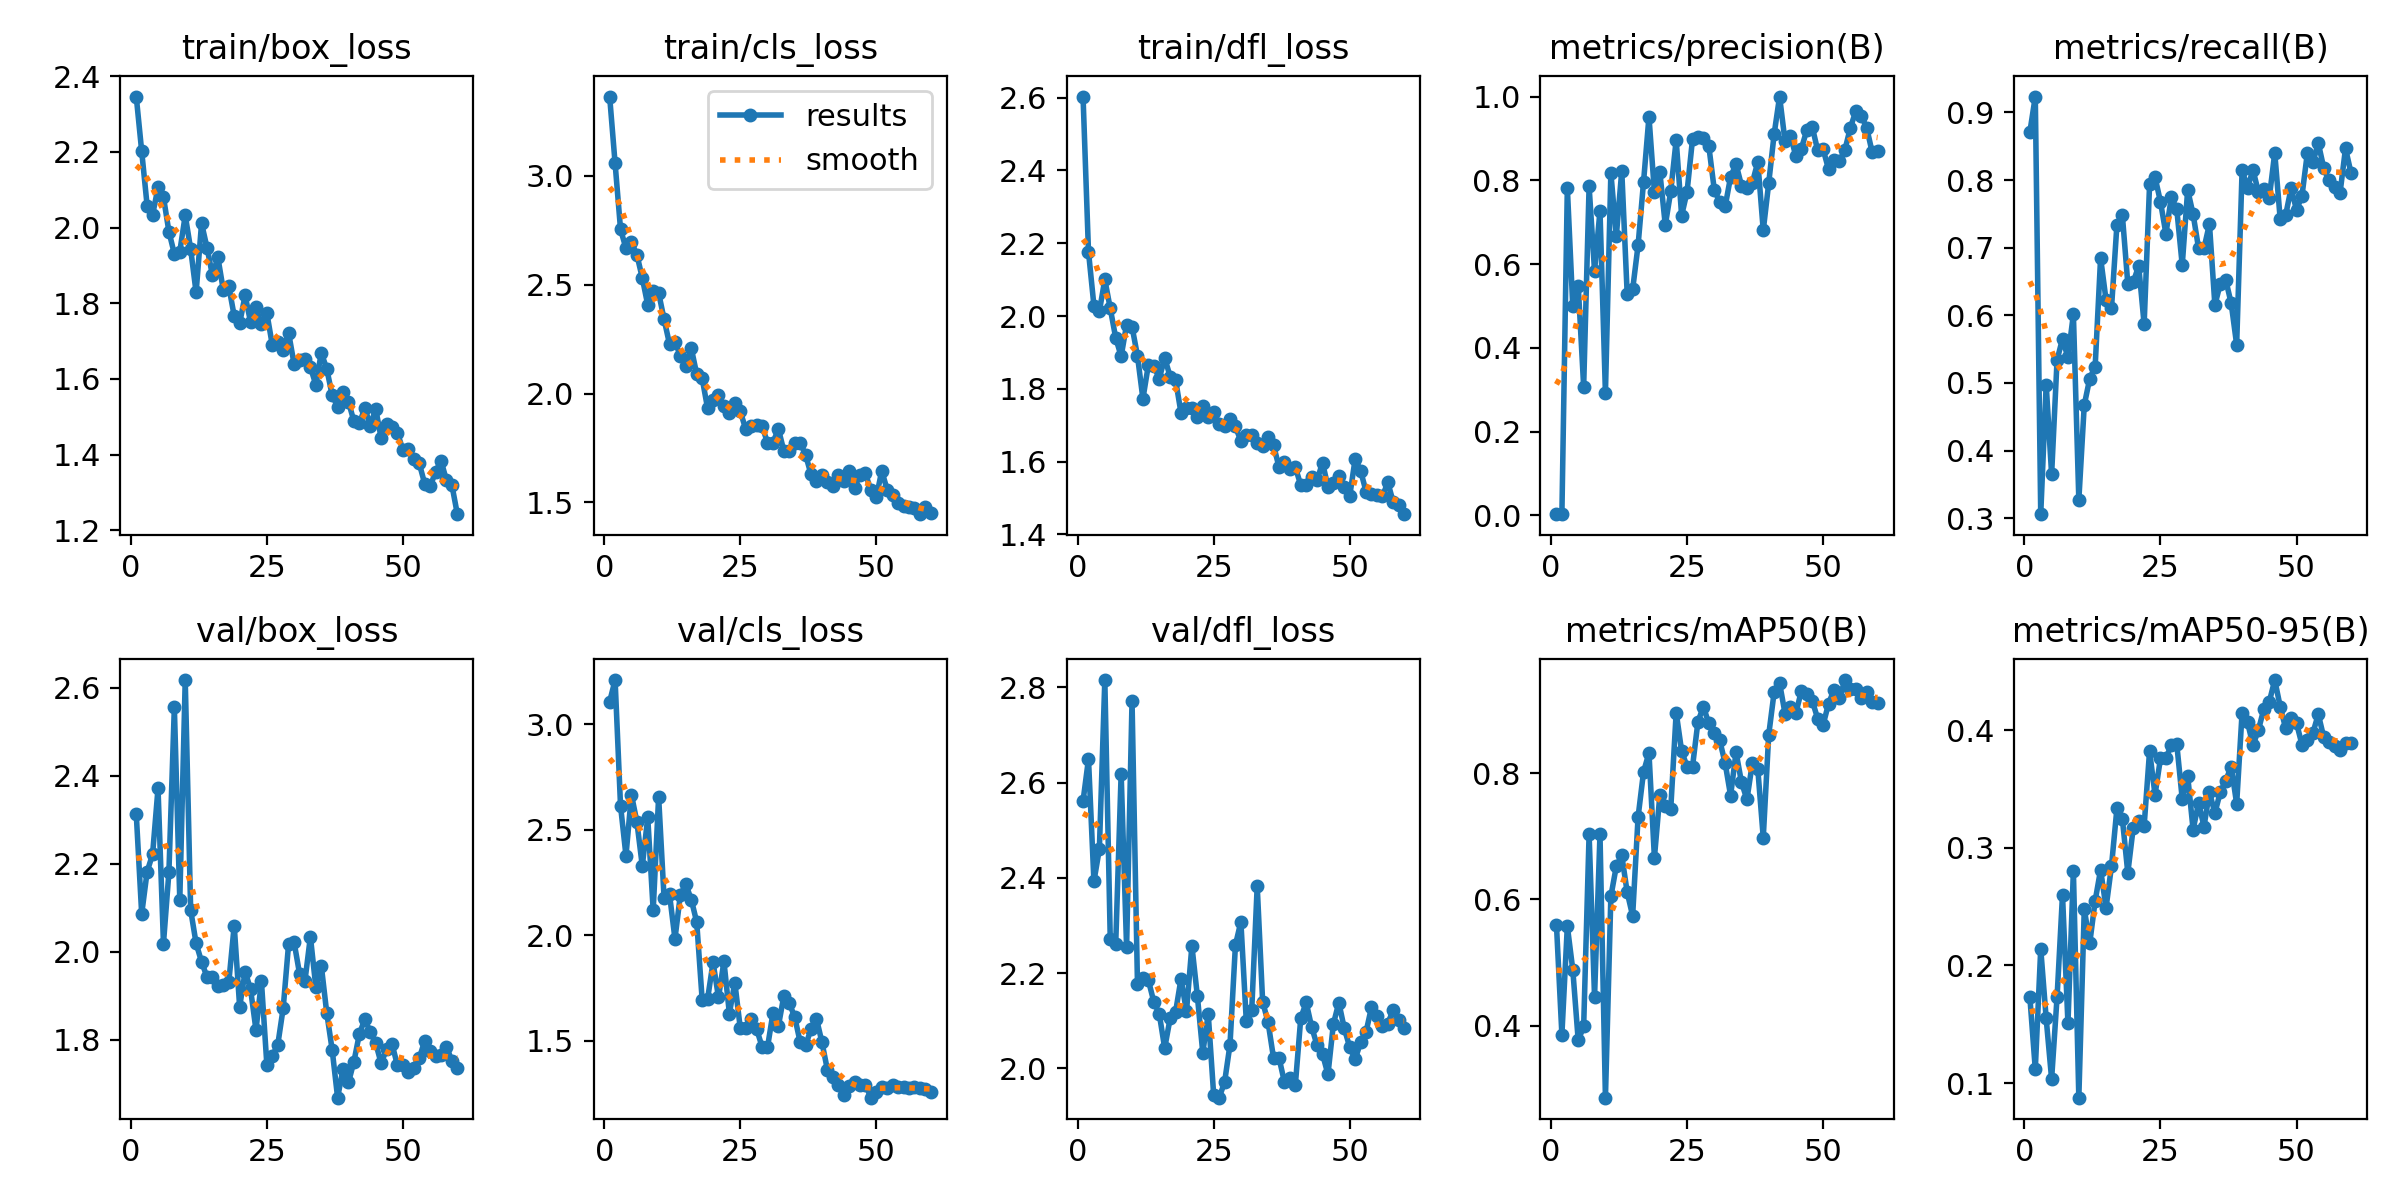

In [ ]:
from IPython.display import Image, display
display(Image("runs/detect/train/results.png", width=900))


12. Eğitilen en iyi modeli (best.pt) alma

In [ ]:
!ls runs/detect/train/weights
!cp runs/detect/train/weights/best.pt /content/best.pt


best.pt  last.pt


13. best.pt dosyasını indirme

In [ ]:
from google.colab import files
files.download("/content/best.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

14. Eğitilen model ile test (validation’dan rastgele bir görsel)

In [ ]:
from ultralytics import YOLO
from IPython.display import Image, display
import random
from pathlib import Path

model = YOLO("/content/best.pt")

val_images = list(Path("/content/dataset/images/val").glob("*.jpg"))
img_path = random.choice(val_images)

print("Testing image:", img_path)

results = model.predict(
    source=str(img_path),
    conf=0.25,
    save=True
)


Testing image: /content/dataset/images/val/apple_img40.jpg

image 1/1 /content/dataset/images/val/apple_img40.jpg: 640x480 1 apple, 58.3ms
Speed: 4.4ms preprocess, 58.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)
Results saved to /content/runs/detect/predict


15. Test sonucunu ekranda gösterme

In [ ]:
display(Image(filename="runs/detect/predict/"+img_path.name, width=700))


Output hidden; open in https://colab.research.google.com to view.